In [1]:
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import tensorflow as tf

import numpy as np
#import seaborn as sns
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(physical_devices))

from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets.mnist import load_data
#from skimage.transform import resize

Num GPUs Available:  1


In [3]:
image_size = 75

ds = tf.keras.preprocessing.image_dataset_from_directory(
    "malevis-train-gan",
    image_size=(image_size,image_size),
    label_mode='int',
    batch_size=128,
)

class_names = ds.class_names

#normalization = layers.experimental.preprocessing.Rescaling(1./255)
#ds = ds.map(lambda x, y: (normalization(x), y))

Found 12394 files belonging to 25 classes.


In [17]:
ds = ds.unbatch()

In [15]:
print(ds.element_spec)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [4]:
fake_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "fake-malevis",
    image_size=(image_size,image_size),
    label_mode='int',
    batch_size=128,
)

#normalization = layers.experimental.preprocessing.Rescaling(1./255)
#fake_ds = fake_ds.map(lambda x, y: (normalization(x), y))

class_names = ds.class_names

Found 12500 files belonging to 25 classes.


In [18]:
fake_ds = fake_ds.unbatch()

In [29]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(image_size,image_size,3))

ds = ds.map(lambda x, y: (preprocess_input(x), y))
fake_ds = fake_ds.map(lambda x, y: (preprocess_input(x), y))

# calculate fid
fid = calculate_fid(model, ds, fake_ds)
print('FID: %.3f' % fid)

FID: 17.405


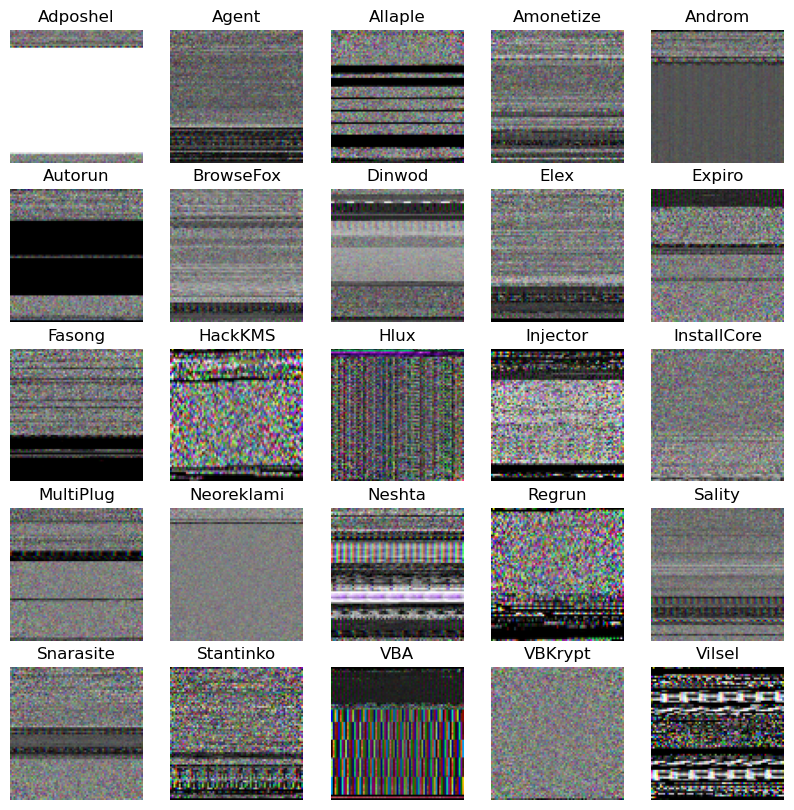

In [7]:
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

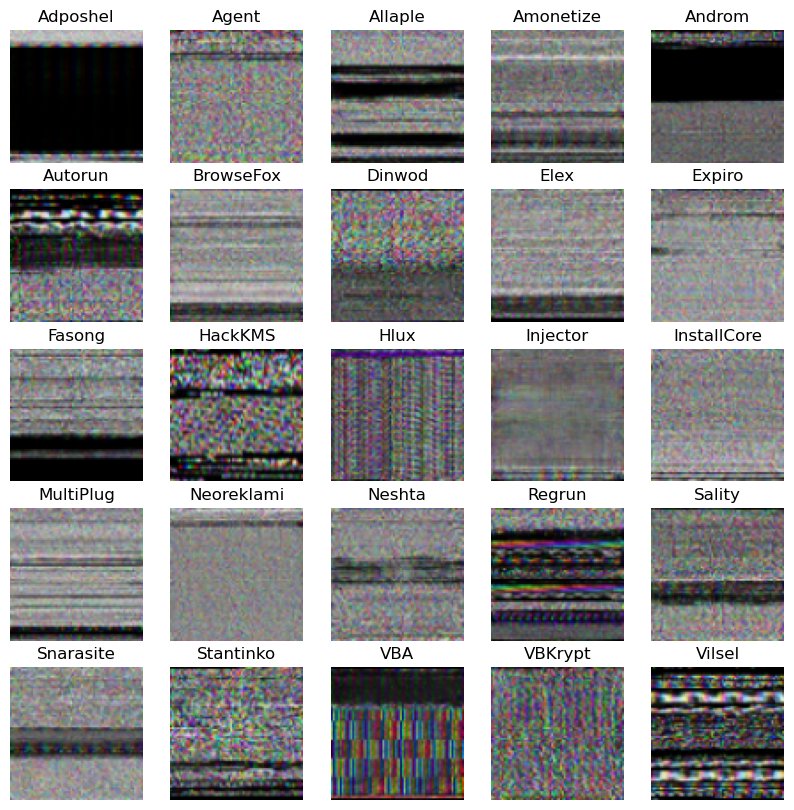

In [10]:
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = fake_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [24]:
#ds.shuffle(buffer_size=1000)
#fake_ds.shuffle(buffer_size=1000)
num_examples = 400

# crea un dizionario per contenere i valori SSIM per ciascuna classe
ssim_dict = {i: [] for i in range(25)}

# loop attraverso le classi
for c in range(25):
    # seleziona solo le immagini della classe corrente
    ds_c = ds.filter(lambda x, y: tf.equal(y, c)).shuffle(buffer_size=num_examples, seed=42).take(num_examples)
    fake_ds_c = fake_ds.filter(lambda x, y: tf.equal(y, c)).shuffle(buffer_size=num_examples, seed=42).take(num_examples)
    
    # loop attraverso le immagini delle due fonti e calcola lo SSIM per ciascuna coppia
    for img_real, img_fake in tf.data.Dataset.zip((ds_c, fake_ds_c)):
        ssim_value = tf.image.ssim(img_real[0], img_fake[0], max_val=1.0)
        ssim_dict[c].append(ssim_value.numpy())

# calcola la media degli SSIM per ciascuna classe
for c in range(26):
    print(f"Classe {c}: media SSIM = {np.mean(ssim_dict[c])}")

KeyboardInterrupt: 

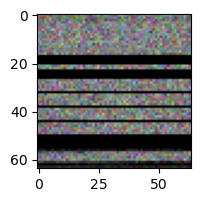

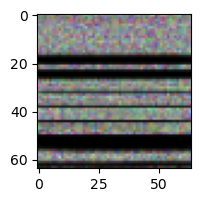

ssim: 0.7370307


In [22]:
img1 = tf.io.read_file('malevis-dataset/2/6bff105f8dd2c141d94beb61ddc4b6b0d8d89085resized_image.png')
img1 = tf.image.decode_png(img1, channels=3)
img1 = tf.image.resize(img1, [64,64])
img1 = img1 / 255.0
plt.figure(figsize=(2,2))
plt.imshow(img1)
plt.show()

img2 = tf.io.read_file('old-fake-malevis/2/2_fake_40.png')
img2 = tf.image.decode_png(img2, channels=3)
img2 = tf.image.resize(img2, [64,64])
img2 = img2 / 255.0
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.show()

#mse = keras.metrics.mean_squared_error(img1, img2)
#mse = tf.reduce_mean(mse).numpy()
ssim = tf.image.ssim(img1, img2, max_val=1.0).numpy()

#print('mse:', mse)
print('ssim:', ssim)

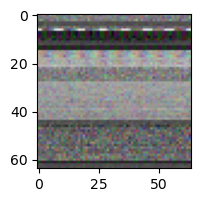

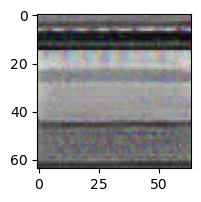

ssim: 0.52542835


In [29]:
img1 = tf.io.read_file('malevis-dataset/7/2bdc877d82abaaf8fb2d09b09410971360b605d5resized_image.png')
img1 = tf.image.decode_png(img1, channels=3)
img1 = tf.image.resize(img1, [64,64])
img1 = img1 / 255.0
plt.figure(figsize=(2,2))
plt.imshow(img1)
plt.show()

img2 = tf.io.read_file('old-fake-malevis/7/7_fake_161.png')
img2 = tf.image.decode_png(img2, channels=3)
img2 = tf.image.resize(img2, [64,64])
img2 = img2 / 255.0
plt.figure(figsize=(2,2))
plt.imshow(img2)
plt.show()

#mse = keras.metrics.mean_squared_error(img1, img2)
#mse = tf.reduce_mean(mse).numpy()
ssim = tf.image.ssim(img1, img2, max_val=1.0).numpy()

#print('mse:', mse)
print('ssim:', ssim)